# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(names, start_date, end_date):
    closes = web.DataReader(name=names,
                            data_source="yahoo",
                           start = start_date,
                           end= end_date)
    return closes["Adj Close"]

In [6]:
# Descargamos datos...
# Instrumento: Amazon
name = "AMZN"
# Fechas de interés (inicio y fin): 2013-2017
start_date, end_date = "2013-01-01", "2017-12-31"
# Función DataReader
closes = get_closes(names = name,
                   start_date = start_date,
                   end_date = end_date)
closes

Date
2013-01-02     257.309998
2013-01-03     258.480011
2013-01-04     259.149994
2013-01-07     268.459991
2013-01-08     266.380005
2013-01-09     266.350006
2013-01-10     265.339996
2013-01-11     267.940002
2013-01-14     272.730011
2013-01-15     271.899994
2013-01-16     268.929993
2013-01-17     270.480011
2013-01-18     272.119995
2013-01-22     270.190002
2013-01-23     268.109985
2013-01-24     273.459991
2013-01-25     283.989990
2013-01-28     276.040009
2013-01-29     260.350006
2013-01-30     272.760010
2013-01-31     265.500000
2013-02-01     265.000000
2013-02-04     259.980011
2013-02-05     266.890015
2013-02-06     262.220001
2013-02-07     260.230011
2013-02-08     261.950012
2013-02-11     257.209991
2013-02-12     258.700012
2013-02-13     269.470001
                 ...     
2017-11-16    1137.290039
2017-11-17    1129.880005
2017-11-20    1126.310059
2017-11-21    1139.489990
2017-11-22    1156.160034
2017-11-24    1186.000000
2017-11-27    1195.829956
2017-11

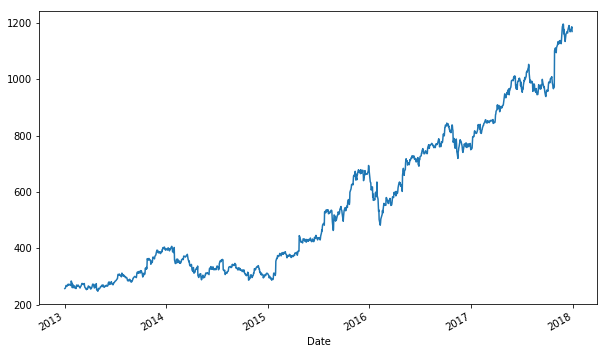

In [7]:
# Graficamos
closes.plot(figsize=(10,6));

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

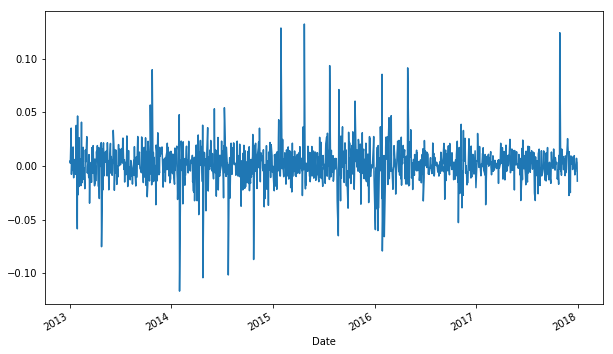

In [8]:
# Calcular a diferencia logarítmica de precios y graficarlos
ret = np.log(closes/closes.shift()).dropna()
ret.plot(figsize=(10,6));

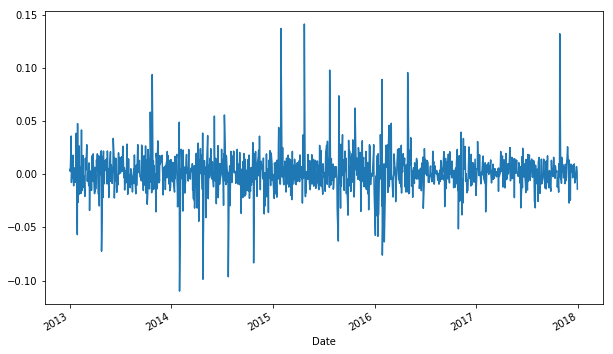

In [9]:
# Calcular rendimientos diarios y graficarlos
ret = ((closes-closes.shift())/closes.shift()).dropna()
ret.plot(figsize=(10,6));

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [11]:
# Calculamos media y desviación estándar
mu, std = ret.mean(), ret.std()
mu, std

(0.001370551552553205, 0.01831605523847909)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2017, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2018 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [13]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    If positive, int_like or int-convertible arguments are provided,
    `randn` generates an array of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1 (if any of the :math:`d_i` are
    floats, they are first converted to integers by truncation). A single
    float randomly sampled from the distribution is returned if no
    argument is provided.
    
    This is a convenience function.  If you want an interface that takes a
    tuple as the first argument, use `numpy.random.standard_normal` instead.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, should be all positive.
        If no argument is given a single Python float is ret

In [18]:
# Función que simula varios escenarios de rendimientos diarios
def ret_sim(mu, std, ndays, nscen, start_date):
    dates= pd.date_range(start=start_date,
                        periods = ndays)
    return pd.DataFrame(data = std*np.random.randn(ndays,nscen) + mu, index=dates)

In [38]:
# Simulamos 100 escenarios para todo el 2018
ndays = 365
nscen = 1000
start_date = "2018-01-01"
simret = ret_sim(mu,std,ndays,nscen,start_date)
simret

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2018-01-01,0.010224,0.024163,0.025689,-0.006974,-0.012434,0.022175,0.003568,-0.019072,-0.024074,-0.003155,...,-0.006764,-0.001185,-0.000751,-0.010345,-0.000207,0.018289,0.004982,0.006094,0.002465,-0.017502
2018-01-02,0.011650,-0.021614,-0.016060,-0.003810,0.041173,-0.007377,0.027235,-0.007791,-0.017912,0.008504,...,-0.013800,0.002557,0.004376,-0.013146,0.004676,0.018419,0.024693,-0.027648,-0.035254,0.001855
2018-01-03,0.031624,0.014621,-0.011119,0.055207,0.010325,-0.022079,0.006968,-0.001716,-0.025047,-0.024596,...,-0.002803,0.015078,0.005368,-0.010356,0.025104,-0.022687,-0.021719,0.002534,0.002665,-0.019018
2018-01-04,-0.005031,-0.001180,0.005430,-0.028832,0.007523,-0.026482,0.008308,0.020232,-0.006847,-0.007625,...,-0.014157,-0.000611,-0.013757,0.038360,-0.005308,-0.003044,-0.009055,-0.010229,0.002840,0.032424
2018-01-05,-0.015373,0.002061,0.028454,0.007048,0.008286,0.000525,0.016469,-0.001742,-0.028226,0.003701,...,0.031183,0.014445,0.031248,0.025255,0.004788,-0.007399,0.008867,-0.005830,-0.014998,0.008055
2018-01-06,-0.023732,-0.004458,-0.029958,0.024712,0.000778,-0.006111,0.004241,-0.005292,0.010143,-0.013635,...,0.000128,-0.007077,0.001768,0.000257,0.025466,0.025700,-0.019399,-0.013455,-0.030001,0.039327
2018-01-07,-0.008041,-0.046223,0.000123,0.028316,-0.008219,0.002555,-0.014974,0.022998,0.037972,0.023105,...,0.003608,0.012543,0.014940,-0.021861,0.001068,-0.010436,0.010754,-0.006861,0.007887,0.001350
2018-01-08,0.034548,-0.017463,0.033455,0.007417,0.014129,-0.005008,0.022671,-0.004182,-0.016701,0.009430,...,-0.015352,-0.019081,-0.003961,-0.003874,0.035132,-0.031536,-0.004492,-0.024207,0.004198,-0.009221
2018-01-09,-0.023583,-0.030990,0.022792,0.001733,-0.007020,-0.043023,0.034706,0.012862,0.007109,-0.014995,...,0.000473,-0.019802,-0.004918,-0.000557,0.004246,-0.009554,-0.007065,-0.008234,-0.017151,0.022897
2018-01-10,-0.003511,0.013599,-0.036677,-0.003705,0.004236,-0.009693,-0.009347,-0.028301,-0.012334,-0.011351,...,0.017731,-0.000692,0.008145,0.000545,0.000332,-0.006815,-0.022259,0.030685,0.001238,-0.013248


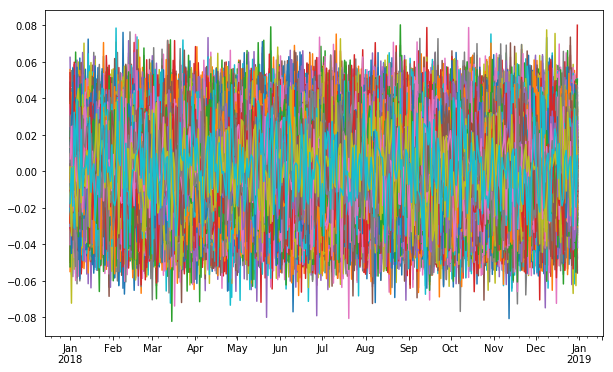

In [39]:
# Mostrar
simret.plot(figsize=(10,6),legend=False);

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2017.

Con los rendimientos, calculamos los precios de cierre...

In [40]:
# Obtenemos los precios
simcloses = closes.iloc[-1]*((1+simret).cumprod())
simcloses

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2018-01-01,1181.427039,1197.728332,1199.511945,1161.313740,1154.928616,1195.403405,1173.642873,1147.165521,1141.316035,1165.780837,...,1161.560122,1168.084136,1168.591688,1157.371718,1169.228255,1190.857971,1175.296433,1176.597296,1172.352135,1149.001892
2018-01-02,1195.190106,1171.840506,1180.247513,1156.888626,1202.480128,1186.585303,1205.607441,1138.228239,1120.872896,1175.695071,...,1145.530739,1171.070432,1173.705653,1142.156438,1174.695737,1212.791821,1204.317448,1144.067274,1131.022494,1151.133308
2018-01-03,1232.987010,1188.973575,1167.124800,1220.757141,1214.895795,1160.386418,1214.007750,1136.275029,1092.798249,1146.777652,...,1142.320156,1188.727532,1180.006003,1130.328143,1204.185750,1185.277610,1178.160742,1146.966804,1134.036635,1129.241618
2018-01-04,1226.784302,1187.570182,1173.462552,1185.560848,1224.035062,1129.657096,1224.093393,1159.264179,1085.316147,1138.034022,...,1126.148361,1188.001795,1163.772642,1173.687169,1197.794003,1181.669606,1167.492922,1135.234700,1137.257152,1165.856554
2018-01-05,1207.925132,1190.017971,1206.852012,1193.916394,1234.177605,1130.249760,1244.253208,1157.244474,1054.681972,1142.246249,...,1161.265171,1205.162758,1200.138345,1203.328968,1203.528518,1172.926288,1177.845022,1128.616627,1120.201059,1175.247957
2018-01-06,1179.258645,1184.712481,1170.696808,1223.420303,1235.137825,1123.342987,1249.530683,1151.120079,1065.379209,1126.671886,...,1161.414263,1196.633372,1202.259827,1203.638794,1234.177280,1203.070317,1154.995713,1113.431302,1086.594217,1221.467093
2018-01-07,1169.775924,1129.951886,1170.840890,1258.062400,1224.986385,1126.212638,1230.819865,1177.593607,1105.833842,1152.703112,...,1165.604646,1211.643277,1220.221976,1177.326088,1235.495831,1190.515258,1167.417086,1105.792080,1095.164524,1223.115626
2018-01-08,1210.188781,1110.219772,1210.011396,1267.393001,1242.293711,1120.572080,1258.723581,1172.668641,1087.365344,1163.573563,...,1147.710816,1188.524497,1215.388905,1172.765540,1278.901208,1152.971076,1162.172899,1079.024426,1099.761561,1211.837048
2018-01-09,1181.649013,1075.814157,1237.589792,1269.589738,1233.573290,1072.361618,1302.408467,1187.751412,1095.095562,1146.125370,...,1148.253117,1164.989430,1209.411783,1172.112892,1284.330802,1141.955886,1153.962155,1070.139576,1080.899560,1239.584682
2018-01-10,1177.500193,1090.444563,1192.198608,1264.886449,1238.799309,1061.967653,1290.235314,1154.136693,1081.588646,1133.115466,...,1168.613361,1164.183215,1219.261882,1172.751349,1284.757060,1134.173062,1128.276212,1102.976886,1082.237679,1223.162179


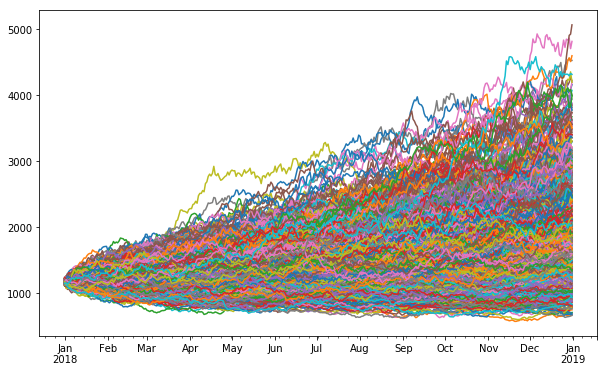

In [41]:
# Graficar
simcloses.plot(figsize=(10,6),legend=False);

In [42]:
closes.iloc[-1]*1.1

1286.4169677734376

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

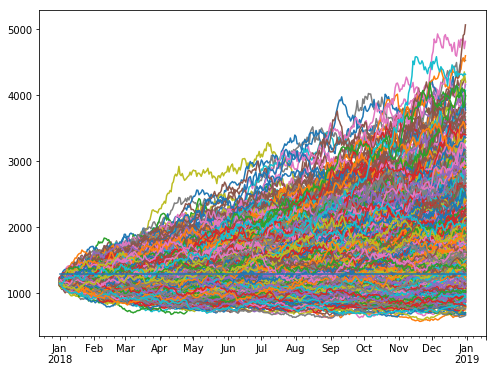

In [43]:
# Umbral de 110% del ultimo precio
K = closes.iloc[-1]*1.1
# Fechas
dates = simcloses.index
# DataFrame de Umbrales
Umbrales = pd.DataFrame(index = dates,columns=['K'], data = K*np.ones(len(dates)))
# Concatenar y graficar
simcloses_K = pd.concat([simcloses.T, Umbrales.T]).T
simcloses_K.plot(figsize=(8,6),legend=False);

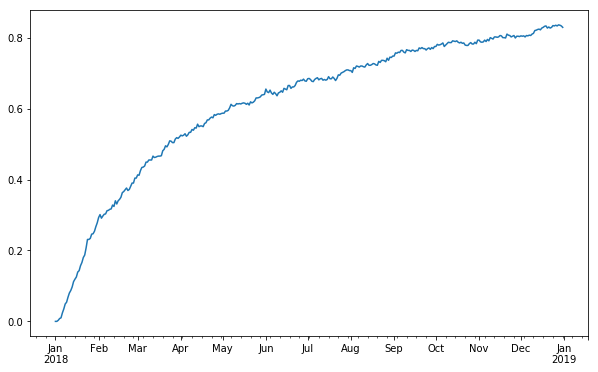

In [44]:
# Comparar cada escenario en cada fecha
Comp = simcloses>K
# Sumamos para cada fecha y dividimos entre el número de escenarios
prob = pd.DataFrame(Comp.sum(axis=1)/nscen)
# Gráfico de probabilidad
prob.plot(figsize=(10,6),legend=False);

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Cristian Camilo Zapata Zuluaga.
</footer>